In [12]:
# Cell 1: 라이브러리 & 설정
import os
import json
import re
import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# 설정값
INPUT_FILE = "project_full_context.txt"
OUTPUT_JSON = "project_flows.json"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 실행 환경: {device.upper()}")

🚀 실행 환경: CUDA


In [13]:
# [Cell 2] 경량화 모델 로더 (3B급)

# ==============================
# 사용하고 싶은 모델 하나만 주석 해제
# ==============================

# 1. [Microsoft] Phi-3.5 (3.8B) - 긴 코드 분석에 최강 (128k 컨텍스트)
MODEL_ID = "microsoft/Phi-3.5-mini-instruct"

# 2. [IBM] Granite 3.0 (3B MoE) - 속도가 가장 빠름 (코딩 특화)
# MODEL_ID = "ibm-granite/granite-3.0-3b-a800m-instruct"

# 3. [Meta] Llama 3.2 (3B) - 한국어/설명 능력이 좋음 (*허깅페이스 로그인 필수*)
# MODEL_ID = "meta-llama/Llama-3.2-3B-Instruct"

# 4. [Google] Gemma 2 (2B) - 가장 가벼움
# MODEL_ID = "google/gemma-2-2b-it"

print(f"🔄 모델 로딩 시작... ({MODEL_ID})")

# 4비트 양자화 설정 (메모리 절약)
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=quantization_config,
        device_map="auto",
        trust_remote_code=False  # Meta 모델의 경우 필요
    )
    print(f"✅ ({MODEL_ID}) 모델 장착 완료! (4-bit 가속 모드)")
except Exception as e:
    print(f"❌ 모델 로드 실패: {e}")

🔄 모델 로딩 시작... (microsoft/Phi-3.5-mini-instruct)


Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.19s/it]


✅ (microsoft/Phi-3.5-mini-instruct) 모델 장착 완료! (4-bit 가속 모드)


In [26]:
# [Cell 3] 프롬프트 매니저 (Router 구조)

# 1. [모드 1] 전체 기능 흐름 파악용
PROMPT_FEATURE_FLOW = """
You are a 'Senior Coding Mentor'. Your job is to visualize the **Complete Data Flow** of a specific feature (e.g., Signup) for a beginner student.

### TARGET
Analyze the codebase and explain the execution path for: "{user_query}"

### CRITICAL REQUIREMENTS
1.  **Don't just list files.** Show the **CONNECTION** between them (From -> To).
2.  **Explain the Data:** What data is moving? (e.g., `req.body` contains `id`, `password`)
3.  **Explain the Why:** Add a simple explanation for each step.

### OUTPUT FORMAT (JSON ONLY - STRICT)
You MUST follow this exact structure. Do not invent your own keys.

{
  "project_summary": "Brief summary of the feature.",
  "flows": [
    {
      "flow_name": "Main Process Flow",
      "sequence": [
        {
          "step": 1,
          "file_context": "Request Start",
          "from": {
            "file": "router/auth.js",
            "code_snippet": "router.post('/signup', ...)",
            "focus_word": "signup"
          },
          "to": {
            "file": "controller/authController.js",
            "code_snippet": "export async function signup(req, res)...",
            "focus_word": "signup"
          },
          "data_transferred": "User ID, Password",
          "beginner_explanation": "The Router catches the user's request and passes the data to the Controller."
        },
        {
          "step": 2,
          "file_context": "Business Logic",
          "from": {
            "file": "controller/authController.js",
            "code_snippet": "await authRepository.createUser(...)",
            "focus_word": "createUser"
          },
          "to": {
            "file": "data/authRepository.js",
            "code_snippet": "export async function createUser(user)...",
            "focus_word": "createUser"
          },
          "data_transferred": "User Object",
          "beginner_explanation": "The Controller asks the Repository to save the new user to the Database."
        }
      ]
    }
  ]
}

### RULES
1. **JSON ONLY**. No markdown.
2. `from` and `to` fields are MANDATORY for drawing arrows.
"""

# 2. [모드 2] 심층 분석 (Caller 찾기 강화)
PROMPT_DEEP_DIVE = """
You are a 'Code Detective'. The user asks about "{user_query}".
Your Goal: Not just explain the function, but find **WHO CALLS IT**.

### CRITICAL TASK
1.  **Find Usage**: Scan the code to find where `{user_query}` is CALLED. (e.g., `login` calls `createJwtToken`)
2.  **Trace Data**: If `login` calls `createJwtToken(user.id)`, show the arrow from `login`'s `user.id` to `createJwtToken`'s `id`.
3.  **Explain Flow**: "Login function generates a token using this function."

### OUTPUT FORMAT (JSON ONLY)
{
  "project_summary": "Deep dive into {user_query}",
  "flows": [
    {
      "flow_name": "Call Graph Analysis",
      "sequence": [
        {
          "step": 1,
          "file_context": "Step 1: Who calls me? (The Caller)",
          "from": {
            "file": "controller/authController.js",
            "code_snippet": "const token = await createJwtToken(user.id);",
            "focus_word": "createJwtToken"
          },
          "to": {
            "file": "controller/authController.js",
            "code_snippet": "async function createJwtToken(id) { ... }",
            "focus_word": "createJwtToken"
          },
          "data_transferred": "user.id -> id",
          "beginner_explanation": "The 'login' or 'signup' function needs a token, so it calls this function by passing the user's ID."
        },
        {
          "step": 2,
          "file_context": "Step 2: Internal Logic",
          "from": {
            "file": "controller/authController.js",
            "code_snippet": "async function createJwtToken(id) { ... }",
            "focus_word": "id"
          },
          "to": {
            "file": "controller/authController.js",
            "code_snippet": "return jwt.sign({ id }, ...)",
            "focus_word": "jwt.sign"
          },
          "data_transferred": "id -> jwt payload",
          "beginner_explanation": "Inside the function, the 'id' is packed into a secure JWT token."
        }
      ]
    }
  ]
}

### RULES
1. **JSON ONLY**.
2. **MUST include at least one 'Caller' step** (Where the function is used).
"""

PROMPT_HEADERS = {
    "feature": PROMPT_FEATURE_FLOW,
    "deep_dive": PROMPT_DEEP_DIVE
}
print("✅ 프롬프트 라우터 업데이트 완료 (호출자 추적 강화)")

✅ 프롬프트 라우터 업데이트 완료 (호출자 추적 강화)


In [27]:
# [Cell 4] 단계별 이미지 분할 생성 (백엔드 전송용)
import os
import json
from PIL import Image, ImageDraw, ImageFont

def visualize_steps_individually():
    """
    JSON 데이터를 읽어서, 각 단계(Step)별로 별도의 이미지를 생성하고 저장합니다.
    반환값: 생성된 이미지 파일 경로들의 리스트
    """
    if not os.path.exists(OUTPUT_JSON):
        print("❌ JSON 파일이 없습니다.")
        return []

    try:
        with open(OUTPUT_JSON, 'r', encoding='utf-8') as f:
            data = json.load(f)
            flows = data.get("flows", [])
    except:
        return []

    if not flows:
        print("⚠️ 시각화할 데이터가 없습니다.")
        return []

    saved_files = [] # 저장된 파일명 리스트

    # 캔버스 설정 (박스 하나가 들어갈 정도의 크기)
    img_width = 1200
    img_height = 400 # 단계별 이미지는 높이가 작아도 됨
    
    try:
        # 폰트 설정 (없으면 기본값)
        font_code = ImageFont.truetype("arial.ttf", 14)
        font_bold = ImageFont.truetype("arialbd.ttf", 16)
        font_desc = ImageFont.truetype("arial.ttf", 14)
    except:
        font_code = ImageFont.load_default()
        font_bold = ImageFont.load_default()
        font_desc = ImageFont.load_default()

    print(f"🎨 단계별 이미지 생성 시작...")

    for flow_idx, flow in enumerate(flows):
        sequence = flow.get('sequence', [])
        
        for step_idx, step in enumerate(sequence):
            # 1. 매 단계마다 새로운 캔버스 생성
            img = Image.new('RGB', (img_width, img_height), color='#1e1e1e')
            draw = ImageDraw.Draw(img)
            
            # 정보 추출
            f_file = step['from'].get('file', 'Unknown')
            f_code = step['from'].get('code_snippet', '').strip()
            t_file = step['to'].get('file', 'Unknown')
            t_code = step['to'].get('code_snippet', '').strip()
            desc = step.get('beginner_explanation', '')
            data_info = step.get('data_transferred', '')

            # --- 제목 표시 ---
            title = f"Step {step_idx + 1}: {desc[:50]}..."
            draw.text((20, 10), title, fill="#FFD700", font=font_bold)

            # --- 왼쪽 박스 (From) ---
            draw.rectangle([50, 50, 550, 180], fill="#252526", outline="#007acc", width=2)
            draw.text((60, 60), f"📄 {f_file}", fill="#569cd6", font=font_bold)
            draw.text((60, 90), f_code[:150], fill="#d4d4d4", font=font_code)

            # --- 오른쪽 박스 (To) ---
            draw.rectangle([750, 50, 1150, 180], fill="#252526", outline="#ce9178", width=2)
            draw.text((760, 60), f"📄 {t_file}", fill="#ce9178", font=font_bold)
            draw.text((760, 90), t_code[:150], fill="#d4d4d4", font=font_code)

            # --- 화살표 & 데이터 ---
            draw.line([(550, 115), (750, 115)], fill="#FFFFFF", width=3)
            draw.polygon([(750, 115), (740, 105), (740, 125)], fill="#FFFFFF")
            
            if data_info:
                draw.text((570, 90), f"📦 {data_info}", fill="#4ec9b0", font=font_code)

            # --- 하단 설명창 ---
            draw.rectangle([50, 220, 1150, 350], fill="#2d2d30", outline="#FFD700", width=1)
            draw.text((70, 240), f"💡 설명: {desc}", fill="#FFFFFF", font=font_desc)

            # 2. 개별 파일로 저장
            filename = f"step_image_{flow_idx}_{step_idx}.png"
            img.save(filename)
            saved_files.append(filename)
            print(f"  ✅ 저장됨: {filename}")

    return saved_files

print("✅ Cell 4 (단계별 분할 시각화) 정의 완료")

✅ Cell 4 (단계별 분할 시각화) 정의 완료


In [ ]:
# [Cell 5] 스마트 문맥 추출 & 모드별 최적화 분석기
import json
import re
import os

# 1. 꼬인 JSON을 풀어주는 함수
def fix_json_structure(text):
    text = text.strip()
    text = re.sub(r",\s*([\]}])", r"\1", text) # 콤마 정리
    
    # 괄호 짝 맞추기
    open_braces = text.count('{')
    close_braces = text.count('}')
    open_brackets = text.count('[')
    close_brackets = text.count(']')
    
    if open_braces > close_braces: text += '}' * (open_braces - close_braces)
    if open_brackets > close_brackets: text += ']' * (open_brackets - close_brackets)
    
    return text

# 2. 검색어가 있는 코드 부분만 쏙 뽑아오는 함수 (Deep Dive용)
def get_relevant_context(full_text, query, window_size=4000):
    index = full_text.find(query)
    if index == -1:
        print(f"⚠️ 경고: '{query}'를 코드에서 찾을 수 없습니다. (전체 범위에서 검색 시도)")
        return full_text[:10000] # 못 찾으면 앞부분 1만자 반환
    
    start_index = max(0, index - window_size // 2)
    end_index = min(len(full_text), index + window_size // 2)
    print(f"🔍 '{query}' 발견! (코드 위치: {start_index} ~ {end_index} 추출)")
    return "...(생략)...\n" + full_text[start_index:end_index] + "\n...(생략)..."

# 3. 분석 실행 함수
def run_analysis(user_query, mode="feature"):
    if not os.path.exists(INPUT_FILE):
        print(f"❌ '{INPUT_FILE}' 파일이 없습니다.")
        return False

    with open(INPUT_FILE, 'r', encoding='utf-8') as f:
        full_code = f.read()

    # 모드에 따른 문맥(Context) 준비 전략 분기
    if mode == "deep_dive":
        # [모드 2] 특정 함수 분석: 해당 단어 주변만 집중 분석
        target_code = get_relevant_context(full_code, user_query)
        system_prompt = PROMPT_HEADERS.get("deep_dive")
    else:
        # [모드 1] 전체 흐름 분석: 전체 코드를 통째로 넣음 (Phi-3.5는 긴 문맥도 처리 가능)
        # 메모리 안전을 위해 50,000자 제한 (필요시 늘려도 됨)
        target_code = full_code[:50000] 
        system_prompt = PROMPT_HEADERS.get("feature")
        print(f"🌍 전체 흐름 모드: 전체 코드(최대 50,000자)를 분석합니다.")

    if not system_prompt:
        system_prompt = "You are a coding expert. Analyze the code flow."

    print(f"🧠 AI 분석 시작: '{user_query}' (모드: {mode})")

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"User Query: {user_query}\n\nCode Context:\n{target_code}"} 
    ]
    
    # LLM 추론
    text_input = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    model_inputs = tokenizer([text_input], return_tensors="pt").to(device)
    
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=2048,
        temperature=0.1,
        do_sample=True
    )
    
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # JSON 정제 및 복구
    clean_text = re.sub(r"^```(json)?", "", response_text.strip(), flags=re.MULTILINE).strip()
    clean_text = re.sub(r"```$", "", clean_text, flags=re.MULTILINE).strip()
    fixed_text = fix_json_structure(clean_text)

    try:
        json_data = json.loads(fixed_text)
        
        # 파일 저장
        with open(OUTPUT_JSON, 'w', encoding='utf-8') as f:
            json.dump(json_data, f, ensure_ascii=False, indent=2)
            
        print(f"✅ JSON 생성 성공! ({OUTPUT_JSON})")
        return True

    except json.JSONDecodeError:
        print("\n❌ JSON 파싱 실패. AI가 이상한 답을 했습니다.")
        print("--- AI 응답 내용 (일부) ---")
        print(clean_text[:500] + "...") 
        # 디버깅용 파일 저장
        with open("error_response.txt", "w", encoding="utf-8") as f:
            f.write(clean_text)
        return False

# --- 실행 예시 ---
# 1. 전체 흐름 볼 때:
# run_analysis("회원가입(Signup) 시 데이터 이동 흐름", mode="feature")

# 2. 특정 함수 볼 때:
run_analysis("createJwtToken", mode="deep_dive")

🔍 'createJwtToken' 발견! (위치: 1167~4167)
🧠 AI 분석 시작: 'createJwtToken' (모드: deep_dive)
✅ JSON 생성 성공! (project_flows.json)


True

🎨 이미지 생성 중...
🎨 단계별 이미지 생성 시작...
  ✅ 저장됨: step_image_0_0.png

✨ 총 1개의 이미지가 생성되었습니다!
- step_image_0_0.png


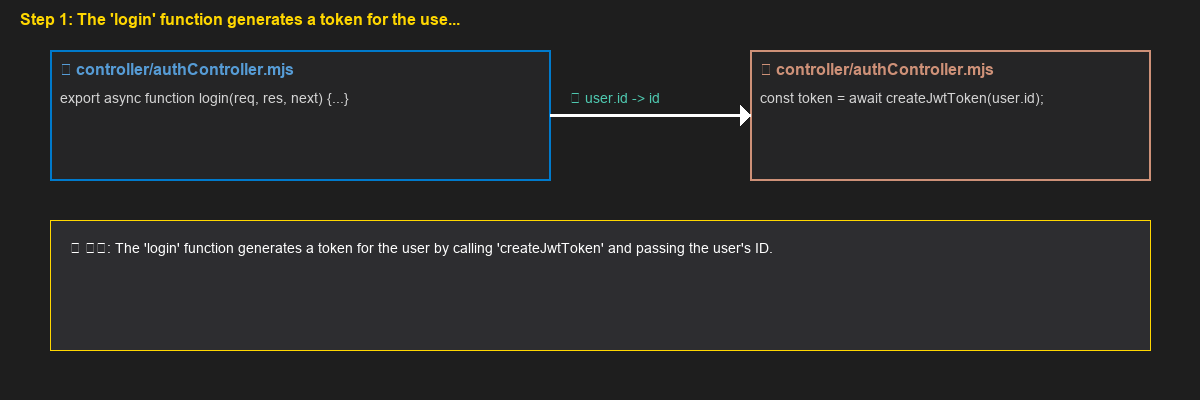

In [29]:
# [Cell 6] 시각화 실행
print("🎨 이미지 생성 중...")
files = visualize_steps_individually()

if files:
    print(f"\n✨ 총 {len(files)}개의 이미지가 생성되었습니다!")
    for f in files:
        print(f"- {f}")
        # 맨 첫 번째 이미지만 미리보기
        if f == files[0]:
            display(Image.open(f))
else:
    print("❌ 생성된 이미지가 없습니다. JSON 분석을 먼저 실행했나요?")

In [8]:
# Cell 7-1: 디버깅 - LLM 응답 확인
print("🔍 디버깅: LLM 응답 상태 확인")

if os.path.exists("debug_response.txt"):
    with open("debug_response.txt", 'r', encoding='utf-8') as f:
        response = f.read()
    print("=== LLM 원본 응답 (첫 1000자) ===")
    print(response[:1000])
    print("\n=== 응답 끝부분 ===")
    print(response[-500:])
else:
    print("❌ debug_response.txt 파일이 없습니다. Cell 7을 먼저 실행하세요.")

🔍 디버깅: LLM 응답 상태 확인
=== LLM 원본 응답 (첫 1000자) ===
{
  "project_summary": "This project is a Node.js application using Express.js for routing, MongoDB with Mongoose for ORM, and JWT for authentication. The application has two main parts: handling user authentication (signup, login, and protected routes) and managing blog posts (creating, reading, updating, and deleting).",
  "flows": [
    {
      "flow_name": "User Signup Process (Data Flow)",
      "sequence": [
        {
          "step": 1,
          "file_context": "Router receives the request",
          "from": {
            "file": "router/auth.mjs",
            "code_snippet": "router.post('/signup', validateSignup, authController.signup);",
            "focus_word": "signup"
          },
          "to": {
            "file": "controller/auth.mjs",
            "code_snippet": "export async function signup(req, res, next) {...}",
            "focus_word": "signup"
          },
          "data_transferred": "req.body (userid, passw